In [31]:
from scipy.stats import skewnorm
import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt

from scores.continuous import mse
from scores.continuous import flip_flop_index_proportion_exceeding, flip_flop_index

The Flip-Flop Index is a way of quantifying the stability of a forecast without penalising a trend which may be expected from a climatological forecast at longer lead-times to a more accurate, and possibly extreme, forecast at shorter lead times. The Flip-Flop Index has the same units as the forecast, with smaller values indicated greater stability. The Flip-Flop Index cannot be used to verify a forecast. Indeed, it does not use the verifying observation in its calculation. However, it describes an (arguably important) characteristic of a forecast system. 

Read about the index at:  
Griffiths et al. (2019) "Flip-Flop Index: Quantifying Revision Stability for Fixed-Event Forecasts", Meteorological Applications, 26(1), pp. 30-35.  
https://doi.org/10.1002/met.1732

And at:  
Griffiths D et al. (2021) "Circular Flip-Flop Index: quantifying revision stability of 
forecasts of direction, 
Journal of Southern Hemisphere Eart 
Systems Science 
71(pp. 3), 266–  
https://doi.org/10.1071/ES21010

The two functions showcased here are the flip_flop_index which calculates the index for individual forecast revision series, and the flip_flop_index_proportion_exceeding which can be used to summarise the Flip-Flop Index values over many forecast revision series by reporting the frequency with which the Flip-Flop Index was observed to exceed values of interest.1010

In [2]:
help(flip_flop_index)

Help on function flip_flop_index in module scores.continuous.flip_flop_impl:

flip_flop_index(data: xarray.core.dataarray.DataArray, sampling_dim: str, is_angular: bool = False, **selections: Optional[collections.abc.Iterable[int]]) -> Union[xarray.core.dataarray.DataArray, xarray.core.dataset.Dataset]
    Calculates the Flip-flop Index along the dimensions `sampling_dim`.
    
    Args:
        data: Data from which to draw subsets.
        sampling_dim: The name of the dimension along which to calculate
            the flip-flop index.
        is_angular: specifies whether `data` is directional data (e.g. wind
            direction).
        **selections: Additional keyword arguments specify
            subsets to draw from the dimension `sampling_dim` of the supplied `data`
            before calculation of the flip_flop index. e.g. days123=[1, 2, 3]
    
    Returns:
        If `selections` are not supplied: An xarray.DataArray, the Flip-flop
        Index by collapsing the dimensi

In [3]:
help(flip_flop_index_proportion_exceeding)

Help on function flip_flop_index_proportion_exceeding in module scores.continuous.flip_flop_impl:

flip_flop_index_proportion_exceeding(data: xarray.core.dataarray.DataArray, sampling_dim: str, thresholds: collections.abc.Iterable, is_angular: bool = False, preserve_dims: Optional[collections.abc.Iterable[collections.abc.Hashable]] = None, reduce_dims: Optional[collections.abc.Iterable[collections.abc.Hashable]] = None, **selections: collections.abc.Iterable[int])
    Calculates the flip-flop index and returns the proportion exceeding
    (or equal to) each of the supplied `thresholds`.
    
    Args:
        data: Data from which to draw subsets.
        sampling_dim: The name of the dimension along which to calculate
        thresholds: The proportion of Flip-Flop index results
            equal to or exceeding these thresholds will be calculated.
            the flip-flop index.
        is_angular: specifies whether `data` is directional data (e.g. wind
            direction).
     

In [5]:
# Create two synthetic forecast revision series.
# These might represent a forecast of 28 degrees a week in advance of the event, updated daily with a forecast of 21 degrees the day before the event.
# Inspection shows that fcsta jumps around while fcst b has a cooler trend each day.
fcsta = xr.DataArray(data=[21., 23, 18, 20, 26, 25, 28], dims="lead_day", coords={"lead_day": np.arange(1, 8)})
fcstb = xr.DataArray(data=[21., 23, 23, 24, 25, 26, 28], dims="lead_day", coords={"lead_day": np.arange(1, 8)})

In [15]:
# The Flip-Flop Index for fcsta quantifies the lack of stability.
flip_flop_index(fcsta, "lead_day")

<xarray.DataArray ()>
array(1.4)
Attributes:
    sampling_dim:  lead_day

In [7]:
# The Flip-Flop Index for fcstb is 0, reflecting no flip-flopping.
flip_flop_index(fcstb, "lead_day")

<xarray.DataArray ()>
array(0.)
Attributes:
    sampling_dim:  lead_day

In [41]:
# Create synthetic temperature observations for 100 days and 100 locations (so, 10,000 observations)
# The values of the observations are between 0 and 40.
obs = 40 * np.random.random((100, 100))
obs = xr.DataArray(
    data=obs, 
    dims=["time", "location number"],
    coords={"time": pd.date_range("2023-01-01", "2023-04-10"), "location number": np.arange(0, 100)}
)

# Create forecasts for 7 lead days
# Each observation has 7 forecast values, issued between 1 and 7 days in advance.
# We create two such forecasts, initially matching the observations, then adding some noise to simulate a forecast
fcst1 = xr.DataArray(data=[1]*7, dims="lead_day", coords={"lead_day": np.arange(1, 8)})
fcst1 = fcst1 * obs
fcst2 = fcst1.copy()

# So, fcst1 is 70,000 forecasts, with 10,000 forecast revision sequences.
# Similarly for fcst2.

# add some noise to the forecasts
# The noise will increase with lead-day reflecting less accurate forecasts at longer lead-days
noise = skewnorm.rvs(4, size=(1, 100, 100))
noise_for_fcst1 = noise.copy()
noise_for_fcst2 = noise.copy()
for lead_day in np.arange(1, 7):
    next_lead_day_noise = (1+lead_day/7)*skewnorm.rvs(4, size=(1, 100, 100))
    noise_for_fcst1 = np.concatenate((noise_for_fcst1, next_lead_day_noise))
    if lead_day % 2 == 0:
        noise_for_fcst2 = np.concatenate((noise_for_fcst2, -1*next_lead_day_noise))
    else:
        noise_for_fcst2 = np.concatenate((noise_for_fcst2, next_lead_day_noise))
fcst1 += noise_for_fcst1
fcst2 += noise_for_fcst2

In [42]:
# Calculate the Mean Square Error to confirm that the forecasts are less accurate at longer lead days
mse(fcst1, obs, preserve_dims=["lead_day"]).round(2)

<xarray.DataArray (lead_day: 7)>
array([0.99, 1.31, 1.62, 2.02, 2.51, 2.93, 3.43])
Coordinates:
  * lead_day  (lead_day) int64 1 2 3 4 5 6 7

In [43]:
# By design, fcst2 has the same absolute errors as fcst1, and hence the same mean square errors.
mse(fcst2, obs, preserve_dims=["lead_day"]).round(2)

<xarray.DataArray (lead_day: 7)>
array([0.99, 1.31, 1.62, 2.02, 2.51, 2.93, 3.43])
Coordinates:
  * lead_day  (lead_day) int64 1 2 3 4 5 6 7

In [45]:
# We can use the flip_flop_index to calculate the Flip-Flop Index for the revision sequence for each date and location.
flip_flop_index(fcst1, "lead_day").round(2)

<xarray.DataArray (time: 100, location number: 100)>
array([[0.12, 0.86, 0.94, ..., 0.42, 0.46, 0.32],
       [1.09, 0.73, 0.99, ..., 0.68, 0.42, 0.48],
       [0.79, 0.62, 0.73, ..., 0.24, 0.47, 0.08],
       ...,
       [1.02, 0.9 , 0.62, ..., 1.18, 1.78, 0.44],
       [0.39, 0.22, 0.43, ..., 0.5 , 0.61, 0.42],
       [1.34, 0.94, 0.84, ..., 1.18, 1.  , 0.29]])
Coordinates:
  * time             (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-04-10
  * location number  (location number) int64 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
Attributes:
    sampling_dim:  lead_day

In [46]:
# We expect fcst2 to be less stable (have more flip-flopping) that fcst1.
# Calculating the frequency with with the Flip-Flop Index exceeds 1 confirms that
# the Flip-Flop index for exceeds 1 only about 20% of the time for fcst1, but well over 80% of the time for fcst2.
# The exact values depend on the random noise generated each time this notebook is run.
print(flip_flop_index_proportion_exceeding(fcst1, "lead_day", [1]).values)
print(flip_flop_index_proportion_exceeding(fcst2, "lead_day", [1]).values)

[0.1844]
[0.8498]


Text(0.5, 1.0, 'Lead Days 1-2-3-4-5-6-7')

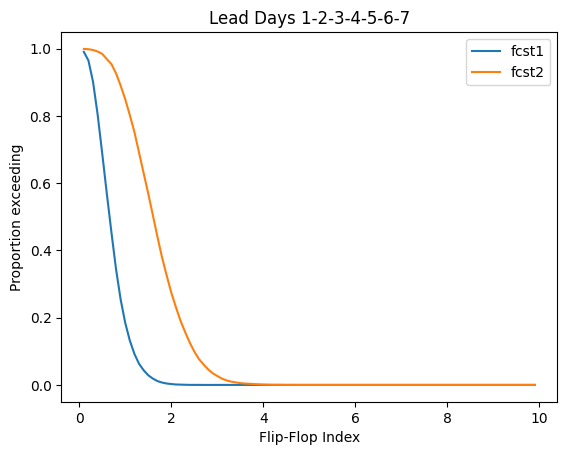

In [48]:
# You can display a graph showing the proportion of times the Flip-Flop exceeds the x-value as is done here.
# The lower line represents the comparative stability fcst1 with the higher line representing the jompiness of fcst2 as a system.
flip_flop_index_proportion_exceeding(fcst1, "lead_day", np.arange(0.1, 10, 0.1)).plot()
flip_flop_index_proportion_exceeding(fcst2, "lead_day", np.arange(0.1, 10, 0.1)).plot()
plt.legend(['fcst1', 'fcst2'])
plt.xlabel("Flip-Flop Index")
plt.ylabel("Proportion exceeding")
plt.title('Lead Days 1-2-3-4-5-6-7')

Text(0.5, 1.0, 'fcst1')

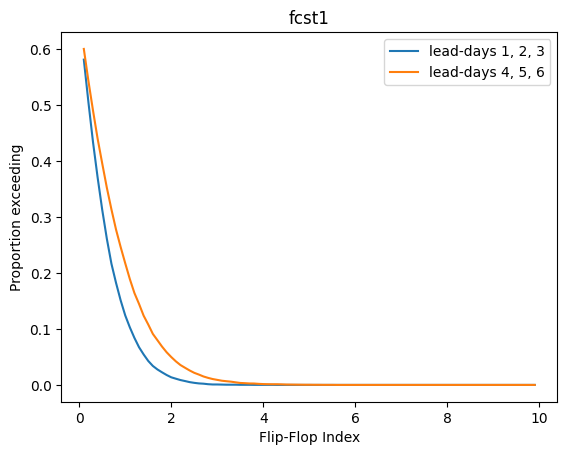

In [38]:
# Considering just fcst1, we can compare the Flip-Flop Index of three forecasts in the revision series.
# We see here that the shorter lead-day forecasts Flip-Flop slightly less than the longer range forecasts.
flip_flop_index_proportion_exceeding(fcst1, "lead_day", np.arange(0.1, 10, 0.1), days123=[1, 2, 3]).days123.plot()
flip_flop_index_proportion_exceeding(fcst1, "lead_day", np.arange(0.1, 10, 0.1), days456=[4, 5, 6]).days456.plot()
plt.legend(['lead-days 1, 2, 3', 'lead-days 4, 5, 6'])
plt.xlabel("Flip-Flop Index")
plt.ylabel("Proportion exceeding")
plt.title('fcst1')